# CNN using coronary heart disease data 

This work is aiming at the design and testing of a deep neural network architecture on Coronary heart disease using Tensorflow and Keras.

## Importing libraries

In [1]:
import numpy as np
import copy
from sklearn import preprocessing

In [2]:
import tensorflow as tf
from tensorflow import keras
import os
import pandas as pd
from matplotlib import pyplot as plt
from numpy.random import seed
np.random.seed(2095)

## Reading the data

In [3]:
# read input file
file = 'C:\\Users\\rohan\\OneDrive\\Documents\\CardiacPrediction_modified.xlsx'
#ipData = pd.read_excel(file, sheet_name='Stroke')
ipData = pd.read_excel(file, sheet_name='CoroHeartDis')
print(ipData.columns) 

Index(['SEQN', 'Gender', 'Age', 'Annual-Family-Income',
       'Ratio-Family-Income-Poverty', 'X60-sec-pulse', 'Systolic', 'Diastolic',
       'Weight', 'Height', 'Body-Mass-Index', 'White-Blood-Cells',
       'Lymphocyte', 'Monocyte', 'Eosinophils', 'Basophils', 'Red-Blood-Cells',
       'Hemoglobin', 'Mean-Cell-Vol', 'Mean-Cell-Hgb-Conc.',
       'Mean-cell-Hemoglobin', 'Platelet-count', 'Mean-Platelet-Vol',
       'Segmented-Neutrophils', 'Hematocrit', 'Red-Cell-Distribution-Width',
       'Albumin', 'ALP', 'AST', 'ALT', 'Cholesterol', 'Creatinine', 'Glucose',
       'GGT', 'Iron', 'LDH', 'Phosphorus', 'Bilirubin', 'Protein', 'Uric.Acid',
       'Triglycerides', 'Total-Cholesterol', 'HDL', 'Glycohemoglobin',
       'Vigorous-work', 'Moderate-work', 'Health-Insurance', 'Diabetes',
       'Blood-Rel-Diabetes', 'Blood-Rel-Stroke', 'CoronaryHeartDisease'],
      dtype='object')


## Drop variables

In [4]:
# data drop
opLabel = np.array(ipData['CoronaryHeartDisease'])
ipData.drop(['SEQN','CoronaryHeartDisease','Annual-Family-Income','Height','Ratio-Family-Income-Poverty','X60-sec-pulse',
          'Health-Insurance','Lymphocyte','Monocyte','Eosinophils','Total-Cholesterol','Mean-Cell-Vol','Mean-Cell-Hgb-Conc.','Hematocrit','Segmented-Neutrophils'], axis = 1, inplace=True)


#opLabel = np.array(ipData['Stroke'])
#ipData.drop(['SEQN','Stroke','Annual-Family-Income','Height','Ratio-Family-Income-Poverty','X60-sec-pulse',
#          'Health-Insurance','Lymphocyte','Monocyte','Eosinophils','Total-Cholesterol','Mean-Cell-Vol','Mean-Cell-Hgb-Conc.','Hematocrit','Segmented-Neutrophils'], axis = 1, inplace=True)



In [5]:
# dummy variable for categorical variables
ipData = pd.get_dummies(ipData,columns=["Gender","Diabetes","Blood-Rel-Diabetes","Blood-Rel-Stroke","Vigorous-work","Moderate-work"]) 

varb = np.array(ipData.columns)
ipData = np.array(ipData)

In [6]:
print(ipData.shape)
print(varb)
print(len(opLabel[opLabel==0]))
print(len(opLabel[opLabel==1]))

(37079, 45)
['Age' 'Systolic' 'Diastolic' 'Weight' 'Body-Mass-Index'
 'White-Blood-Cells' 'Basophils' 'Red-Blood-Cells' 'Hemoglobin'
 'Mean-cell-Hemoglobin' 'Platelet-count' 'Mean-Platelet-Vol'
 'Red-Cell-Distribution-Width' 'Albumin' 'ALP' 'AST' 'ALT' 'Cholesterol'
 'Creatinine' 'Glucose' 'GGT' 'Iron' 'LDH' 'Phosphorus' 'Bilirubin'
 'Protein' 'Uric.Acid' 'Triglycerides' 'HDL' 'Glycohemoglobin' 'Gender_1'
 'Gender_2' 'Diabetes_1' 'Diabetes_2' 'Diabetes_3' 'Blood-Rel-Diabetes_1'
 'Blood-Rel-Diabetes_2' 'Blood-Rel-Stroke_1' 'Blood-Rel-Stroke_2'
 'Vigorous-work_1' 'Vigorous-work_2' 'Vigorous-work_3' 'Moderate-work_1'
 'Moderate-work_2' 'Moderate-work_3']
35571
1508


## Feature Nomination using LASSO

In [7]:
#Data condensation using LASSO penalty
from sklearn.linear_model import Lasso, LogisticRegression


featureVote = np.zeros(ipData.shape[1])
print(featureVote.shape)

iteR = 100

for num in range(iteR):
    label0_indx = np.where(opLabel==0)[0]   #no coronary heart disease
    label1_indx = np.where(opLabel==1)[0]   #coronary heart disease 
    numTrainData0 = 1300
    numTrainData1 = 1300
    np.random.shuffle(label0_indx)
    np.random.shuffle(label1_indx)
    
    label0_indx_train = label0_indx[0:numTrainData0-1]
    label1_indx_train = label1_indx[0:numTrainData1-1]
    label0_indx_test  = label0_indx[numTrainData0-1:]
    label1_indx_test  = label1_indx[numTrainData1-1:]
    
    testIndx  = np.append(label0_indx_test,label1_indx_test)
    trainIndx = np.append(label0_indx_train,label1_indx_train)    
    trainData  =  ipData[trainIndx]
    trainLabel =  opLabel[trainIndx]
    testData   =  ipData[testIndx]
    testLabel  =  opLabel[testIndx]    
    
    ##%% data standardization
    scaler = preprocessing.StandardScaler().fit(trainData)
    trainData_scaled = scaler.transform(trainData)
    testData_scaled  = scaler.transform(testData)
    
    ##%% Elastic net and Lasso from scikit
    #regr = ElasticNet(random_state=0, alpha=1, l1_ratio=0.03, tol=0.000001, max_iter=100000)
    regr = Lasso(random_state=0, alpha=0.006, tol=0.000001, max_iter=100000)
    #regr = LogisticRegression(penalty='l1',random_state=0,C=100,tol=0.000001,max_iter=100,class_weight='balanced')
    regr.fit(trainData_scaled,trainLabel)
    cof = np.abs(regr.coef_)    
    colIndx = np.where(cof != 0)[0]
    for col in colIndx:
        featureVote[col]+=1


(45,)


In [8]:
print(featureVote)
print(iter)

[100.  33.  82.  39.  14.  91.  50.  67.   9.  19. 100.  49. 100.  47.
  26.  24.   9. 100.  88.  14.  36.  33. 100.  24.  47.  25. 100.  99.
  96.  95. 100.  39.  86.  73.   5.  87.  47. 100.  52.  14.  13.  89.
   2.  99.  64.]
<built-in function iter>


In [9]:
# feature nomination via Lasso (from feature 1 to 30)
# We keep the dummy variables

#thresH = iteR//5. Pick features occuring more than 5 times
thresH = 0
featureIndx = np.where(featureVote[0:30]>=thresH)[0]
featureIndx = np.append(featureIndx, np.arange(30,ipData.shape[1]))
print(varb[featureIndx])

['Age' 'Systolic' 'Diastolic' 'Weight' 'Body-Mass-Index'
 'White-Blood-Cells' 'Basophils' 'Red-Blood-Cells' 'Hemoglobin'
 'Mean-cell-Hemoglobin' 'Platelet-count' 'Mean-Platelet-Vol'
 'Red-Cell-Distribution-Width' 'Albumin' 'ALP' 'AST' 'ALT' 'Cholesterol'
 'Creatinine' 'Glucose' 'GGT' 'Iron' 'LDH' 'Phosphorus' 'Bilirubin'
 'Protein' 'Uric.Acid' 'Triglycerides' 'HDL' 'Glycohemoglobin' 'Gender_1'
 'Gender_2' 'Diabetes_1' 'Diabetes_2' 'Diabetes_3' 'Blood-Rel-Diabetes_1'
 'Blood-Rel-Diabetes_2' 'Blood-Rel-Stroke_1' 'Blood-Rel-Stroke_2'
 'Vigorous-work_1' 'Vigorous-work_2' 'Vigorous-work_3' 'Moderate-work_1'
 'Moderate-work_2' 'Moderate-work_3']


In [10]:
featureIndx.shape

(45,)

In [11]:
tInx = np.arange(ipData.shape[1])
rrInx = tInx[~np.isin(tInx,featureIndx)]
print(varb[rrInx])

[]


# Dataset reduction (Re-run every time you change the number of training data)

In [12]:

reduced_data = ipData[:,featureIndx]

label0_indx = np.where(opLabel==0)[0]   #no cardiac arrest
label1_indx = np.where(opLabel==1)[0]   #cardiac arrest 
numTrainData0 = 4300
numTrainData1 = 1169
np.random.shuffle(label0_indx)
np.random.shuffle(label1_indx)

label0_indx_train = label0_indx[0:numTrainData0]
label1_indx_train = label1_indx[0:numTrainData1]
label0_indx_test  = label0_indx[numTrainData0:]
label1_indx_test  = label1_indx[numTrainData1:]

testIndx  = np.append(label0_indx_test,label1_indx_test)
trainIndx = np.append(label0_indx_train,label1_indx_train)    
x_train  =  reduced_data[trainIndx]
y_train  =  opLabel[trainIndx]
x_test   =  reduced_data[testIndx]
y_test   =  opLabel[testIndx]    

In [13]:
print(len(label0_indx_test))

31271


In [14]:
scaler = preprocessing.StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test  = scaler.transform(x_test)

x_train_org = copy.deepcopy(x_train)
x_test_org  = copy.deepcopy(x_test)
y_train_org     = copy.deepcopy(y_train)
y_test_org      = copy.deepcopy(y_test)

## t-SNE visualization

In [15]:
# t-SNE visualization
import imblearn
from collections import Counter
from sklearn.manifold import TSNE
import seaborn as sns

In [16]:
X_embedded = TSNE(n_components=3, n_iter = 300, verbose=1).fit_transform(x_train)


C:\Users\rohan\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\rohan\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5469 samples in 0.000s...
[t-SNE] Computed neighbors for 5469 samples in 0.762s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5469
[t-SNE] Computed conditional probabilities for sample 2000 / 5469
[t-SNE] Computed conditional probabilities for sample 3000 / 5469
[t-SNE] Computed conditional probabilities for sample 4000 / 5469
[t-SNE] Computed conditional probabilities for sample 5000 / 5469
[t-SNE] Computed conditional probabilities for sample 5469 / 5469
[t-SNE] Mean sigma: 1.776332
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.262047
[t-SNE] KL divergence after 300 iterations: 2.202406


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


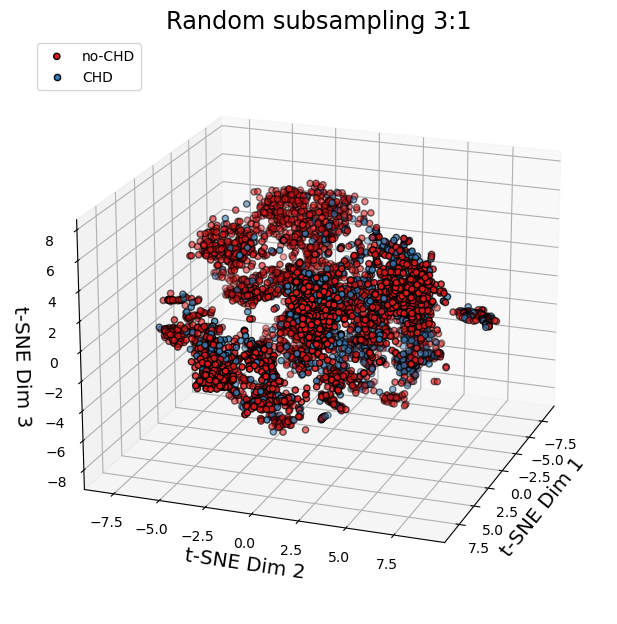

In [17]:
from mpl_toolkits.mplot3d import Axes3D

cin = sns.color_palette("Set1")[1]
edge_color = []
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('w')
ax.scatter(X_embedded[:,0],X_embedded[:,1],X_embedded[:,2],c=[sns.color_palette("Set1")[x] for x in y_train],\
           edgecolors='k',label='no-CHD')
ax.scatter(0,0,0,c=cin,edgecolors='k',label='CHD')
ax.azim = 20
ax.elev = 20
ax.set_xlabel("t-SNE Dim 1", size="x-large")
ax.set_ylabel("t-SNE Dim 2", size="x-large")
ax.set_zlabel("t-SNE Dim 3", size="x-large")
plt.title("Random subsampling 3:1",size="xx-large")
ax.legend(loc='upper left')
fig.set_size_inches(7.5,7.5)
fig.savefig('tSNE_RUS.png', dpi=100)

In [18]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [19]:
#%% one-hot-encoding
y_train = keras.utils.to_categorical(y_train,2)
y_test  = keras.utils.to_categorical(y_test,2)

In [20]:
#y_train.shape
#y_train
y_train_org

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

# Running the part above is MANDATORY for training any Network below

# Introducing convolutional layers

## MLP+Conv :: Input => Hidden(128)  => Conv(4) => Output (2)

In [116]:

inputs = keras.layers.Input(shape=(x_train.shape[1],1))
RS0    = keras.layers.Reshape((x_train.shape[1], ))(inputs)
FC0    = keras.layers.Dense(128, bias_initializer=keras.initializers.VarianceScaling())(RS0)
BN0    = keras.layers.BatchNormalization(axis=-1)(FC0)
AC0    = keras.layers.Activation('relu')(BN0)
DP0    = keras.layers.Dropout(0.2)(AC0)

RS1    = keras.layers.Reshape((128,1))(DP0)
FC1    = keras.layers.Conv1D(4,3,strides=1)(RS1)
BN1    = keras.layers.BatchNormalization(axis=-1)(FC1)
AC1    = keras.layers.Activation('relu')(BN1)
Pool1 = keras.layers.MaxPool1D(pool_size=2)(AC1)
FL1   = keras.layers.Flatten()(Pool1)

FC3 =   keras.layers.Dense(2, bias_initializer=keras.initializers.VarianceScaling())(FL1)
outputs = keras.layers.Activation('softmax')(FC3)

myCNN1D1 = keras.Model(inputs=inputs,outputs=outputs)
myCNN1D1.compile(optimizer=keras.optimizers.Adam(),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

myCNN1D1.summary()


Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 45, 1)]           0         
_________________________________________________________________
reshape_30 (Reshape)         (None, 45)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 128)               5888      
_________________________________________________________________
batch_normalization_49 (Batc (None, 128)               512       
_________________________________________________________________
activation_65 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 128)               0         
_________________________________________________________________
reshape_31 (Reshape)         (None, 128, 1)            0  

In [117]:
class_weight = {0: 1, 1: 4}

myCNN1D1.fit(x_train,y_train,epochs=1,verbose=1, class_weight=class_weight)

171/171 [==============================] - 1s 2ms/step - loss: 0.9696 - accuracy: 0.6802


In [118]:
test_loss,test_acc = myCNN1D1.evaluate(x_test,y_test)
print(test_acc)

988/988 [==============================] - 1s 1ms/step - loss: 0.6822 - accuracy: 0.6400
0.6399556994438171


In [119]:
from sklearn import metrics
predlabel = myCNN1D1.predict(x_test)
f = np.argmax(predlabel,axis=1)
confMat = metrics.confusion_matrix(np.argmax(y_test,axis=1),f)
print(confMat)

[[19929 11342]
 [   39   300]]


##  MLP+CONV: Input => Hidden(128)  => Conv(4) => Conv(8) => Output (2)

In [120]:
inputs = keras.layers.Input(shape=(x_train.shape[1],1))
RS0    = keras.layers.Reshape((x_train.shape[1], ))(inputs)
FC0    = keras.layers.Dense(128, bias_initializer=keras.initializers.VarianceScaling())(RS0)
BN0    = keras.layers.BatchNormalization(axis=-1)(FC0)
AC0    = keras.layers.Activation('relu')(BN0)
DP0    = keras.layers.Dropout(0.2)(AC0)

RS1    = keras.layers.Reshape((128,1))(DP0)
FC1    = keras.layers.Conv1D(4,3,strides=1)(RS1)
BN1    = keras.layers.BatchNormalization(axis=-1)(FC1)
AC1    = keras.layers.Activation('relu')(BN1)
Pool1 = keras.layers.AveragePooling1D(pool_size=2)(AC1)

FC2    = keras.layers.Conv1D(8,5,strides=1)(Pool1)
BN2    = keras.layers.BatchNormalization(axis=-1)(FC2)
AC2    = keras.layers.Activation('relu')(BN2)
Pool2 = keras.layers.AveragePooling1D(pool_size=2)(AC2)

FL1   = keras.layers.Flatten()(Pool2)

FC3 =   keras.layers.Dense(2, bias_initializer=keras.initializers.VarianceScaling())(FL1)
outputs = keras.layers.Activation('softmax')(FC3)

myCNN1D2 = keras.Model(inputs=inputs,outputs=outputs)
myCNN1D2.compile(optimizer=keras.optimizers.Adam(),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

myCNN1D2.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 45, 1)]           0         
_________________________________________________________________
reshape_32 (Reshape)         (None, 45)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 128)               5888      
_________________________________________________________________
batch_normalization_51 (Batc (None, 128)               512       
_________________________________________________________________
activation_68 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 128)               0         
_________________________________________________________________
reshape_33 (Reshape)         (None, 128, 1)            0  

In [121]:
class_weight = {0: 1, 1: 4.5}

myCNN1D2.fit(x_train,y_train,epochs=1,verbose=1, class_weight=class_weight)

171/171 [==============================] - 1s 3ms/step - loss: 1.0065 - accuracy: 0.6444


In [122]:
test_loss,test_acc = myCNN1D2.evaluate(x_test,y_test)
print(test_acc)

988/988 [==============================] - 1s 1ms/step - loss: 0.9439 - accuracy: 0.2730
0.2730148732662201


In [123]:
from sklearn import metrics
predlabel = myCNN1D2.predict(x_test)
f = np.argmax(predlabel,axis=1)
confMat = metrics.confusion_matrix(np.argmax(y_test,axis=1),f)
print(confMat)

[[ 8296 22975]
 [    5   334]]


## MLP+Conv :: Input => Hidden(64) => Conv(2) => Hidden(512)  

In [124]:

inputs = keras.layers.Input(shape=(x_train.shape[1],1))
RS0    = keras.layers.Reshape((x_train.shape[1], ))(inputs)
FC0    = keras.layers.Dense(32, bias_initializer=keras.initializers.VarianceScaling())(RS0)
BN0    = keras.layers.BatchNormalization(axis=-1)(FC0)
AC0    = keras.layers.Activation('relu')(BN0)
DP0    = keras.layers.Dropout(0.2)(AC0)

RS1    = keras.layers.Reshape((32,1))(DP0)
FC1    = keras.layers.Conv1D(2,3,strides=1)(RS1)
BN1    = keras.layers.BatchNormalization(axis=-1)(FC1)
AC1    = keras.layers.Activation('relu')(BN1)
Pool1 = keras.layers.MaxPool1D(pool_size=2)(AC1)
FL1   = keras.layers.Flatten()(Pool1)

FC2    = keras.layers.Dense(512, bias_initializer=keras.initializers.VarianceScaling())(FL1)
BN2    = keras.layers.BatchNormalization(axis=-1)(FC2)
AC2    = keras.layers.Activation('relu')(BN2)
#DP2    = keras.layers.Dropout(0.2)(AC2)


FC3 =   keras.layers.Dense(2, bias_initializer=keras.initializers.VarianceScaling())(AC2)
outputs = keras.layers.Activation('softmax')(FC3)

myCNN1D3 = keras.Model(inputs=inputs,outputs=outputs)
myCNN1D3.compile(optimizer=keras.optimizers.Adam(),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
myCNN1D3.summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 45, 1)]           0         
_________________________________________________________________
reshape_34 (Reshape)         (None, 45)                0         
_________________________________________________________________
dense_47 (Dense)             (None, 32)                1472      
_________________________________________________________________
batch_normalization_54 (Batc (None, 32)                128       
_________________________________________________________________
activation_72 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 32)                0         
_________________________________________________________________
reshape_35 (Reshape)         (None, 32, 1)             0  

In [125]:
class_weight = {0: 1, 1: 50}

myCNN1D3.fit(x_train,y_train,epochs=5,verbose=1, class_weight=class_weight)

Epoch 1/5
171/171 [==============================] - 1s 2ms/step - loss: 2.8199 - accuracy: 0.3169
Epoch 2/5
171/171 [==============================] - 0s 2ms/step - loss: 2.3918 - accuracy: 0.3743
Epoch 3/5
171/171 [==============================] - 0s 2ms/step - loss: 2.3574 - accuracy: 0.3937
Epoch 4/5
171/171 [==============================] - 0s 2ms/step - loss: 2.1606 - accuracy: 0.4306
Epoch 5/5
171/171 [==============================] - 0s 2ms/step - loss: 2.2601 - accuracy: 0.4229


In [126]:
test_loss,test_acc = myCNN1D3.evaluate(x_test,y_test)
print(test_acc)

988/988 [==============================] - 1s 988us/step - loss: 1.2744 - accuracy: 0.4209
0.4208794832229614


In [127]:
from sklearn import metrics
predlabel = myCNN1D3.predict(x_test)
f = np.argmax(predlabel,axis=1)
confMat = metrics.confusion_matrix(np.argmax(y_test,axis=1),f)
print(confMat)

[[12974 18297]
 [    9   330]]


## MLP+ CONV: Input => Dense(64) => Conv(2) => Conv(4) = Dense(512) => Dense (2) [Best model]

In [128]:
inputs = keras.layers.Input(shape=(x_train.shape[1],1))
RS0    = keras.layers.Reshape((x_train.shape[1], ))(inputs)
FC0    = keras.layers.Dense(64, bias_initializer=keras.initializers.VarianceScaling())(RS0)
BN0    = keras.layers.BatchNormalization(axis=-1)(FC0)
AC0    = keras.layers.Activation('relu')(BN0)
DP0    = keras.layers.Dropout(0.2)(AC0)

RS1    = keras.layers.Reshape((64,1))(DP0)
FC1    = keras.layers.Conv1D(2,3,strides=1)(RS1)
BN1    = keras.layers.BatchNormalization(axis=-1)(FC1)
AC1    = keras.layers.Activation('relu')(BN1)
Pool1  = keras.layers.AveragePooling1D(pool_size=2)(AC1)

FC2    = keras.layers.Conv1D(4,5,strides=1)(Pool1)
BN2    = keras.layers.BatchNormalization(axis=-1)(FC2)
AC2    = keras.layers.Activation('relu')(BN2)
Pool2  = keras.layers.AveragePooling1D(pool_size=2)(AC2)

FL1    = keras.layers.Flatten()(Pool2)

FC3    = keras.layers.Dense(512, bias_initializer=keras.initializers.VarianceScaling())(FL1)
BN3    = keras.layers.BatchNormalization(axis=-1)(FC3)
AC3    = keras.layers.Activation('relu')(BN3)
DP3    = keras.layers.Dropout(0.2)(AC3)


FC4    = keras.layers.Dense(2)(DP3)
outputs = keras.layers.Activation('softmax')(FC4)

myCNN1D4 = keras.Model(inputs=inputs,outputs=outputs)
myCNN1D4.compile(optimizer=keras.optimizers.Adam(),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

#myCNN1D4.summary()

In [129]:
class_weight = {0: 1, 1: 2.9}

myCNN1D4.fit(x_train,y_train,epochs=1,verbose=1, class_weight=class_weight)

171/171 [==============================] - 1s 3ms/step - loss: 0.9540 - accuracy: 0.6934


In [130]:
test_loss,test_acc = myCNN1D4.evaluate(x_test,y_test)
print(test_acc)

988/988 [==============================] - 2s 1ms/step - loss: 0.5208 - accuracy: 0.8569
0.8569440245628357


In [131]:
from sklearn import metrics
predlabel = myCNN1D4.predict(x_test)
f = np.argmax(predlabel,axis=1)
confMat = metrics.confusion_matrix(np.argmax(y_test,axis=1),f)
print(confMat)

[[26902  4369]
 [  153   186]]


In [132]:
y_train @ np.transpose(np.array([0, 1]))
1/41

0.024390243902439025

## Input => Dense(64) => Conv(2) => Conv(4) = Conv(8) => Dense (2)

In [133]:
inputs = keras.layers.Input(shape=(x_train.shape[1],1))
RS0    = keras.layers.Reshape((x_train.shape[1], ))(inputs)
FC0    = keras.layers.Dense(64, bias_initializer=keras.initializers.VarianceScaling())(RS0)
BN0    = keras.layers.BatchNormalization(axis=-1)(FC0)
AC0    = keras.layers.Activation('relu')(BN0)
DP0    = keras.layers.Dropout(0.2)(AC0)

RS1    = keras.layers.Reshape((64,1))(DP0)
FC1    = keras.layers.Conv1D(2,3,strides=1)(RS1)
BN1    = keras.layers.BatchNormalization(axis=-1)(FC1)
AC1    = keras.layers.Activation('relu')(BN1)
Pool1  = keras.layers.AveragePooling1D(pool_size=2)(AC1)

FC2    = keras.layers.Conv1D(4,5,strides=1)(Pool1)
BN2    = keras.layers.BatchNormalization(axis=-1)(FC2)
AC2    = keras.layers.Activation('relu')(BN2)
Pool2  = keras.layers.AveragePooling1D(pool_size=2)(AC2)


FC3    = keras.layers.Conv1D(6,7,strides=1)(Pool2)
BN3    = keras.layers.BatchNormalization(axis=-1)(FC3)
AC3    = keras.layers.Activation('relu')(BN3)
Pool3  = keras.layers.AveragePooling1D(pool_size=2)(AC3)




FL1    = keras.layers.Flatten()(Pool3)

#FC3    = keras.layers.Dense(512, bias_initializer=keras.initializers.VarianceScaling())(FL1)
#BN3    = keras.layers.BatchNormalization(axis=-1)(FC3)
#AC3    = keras.layers.Activation('relu')(BN3)
#DP3    = keras.layers.Dropout(0.2)(AC3)


FC4    = keras.layers.Dense(2)(FL1)
outputs = keras.layers.Activation('softmax')(FC4)

myCNN5D4 = keras.Model(inputs=inputs,outputs=outputs)
myCNN5D4.compile(optimizer=keras.optimizers.Adam(),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

myCNN5D4.summary()


Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 45, 1)]           0         
_________________________________________________________________
reshape_38 (Reshape)         (None, 45)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 64)                2944      
_________________________________________________________________
batch_normalization_61 (Batc (None, 64)                256       
_________________________________________________________________
activation_81 (Activation)   (None, 64)                0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 64)                0         
_________________________________________________________________
reshape_39 (Reshape)         (None, 64, 1)             0  

In [134]:
class_weight = {0: 1, 1: 3.0}

myCNN5D4.fit(x_train,y_train,epochs=1,verbose=1, class_weight=class_weight)

171/171 [==============================] - 1s 2ms/step - loss: 0.9279 - accuracy: 0.6292


In [135]:
test_loss,test_acc = myCNN5D4.evaluate(x_test,y_test)
print(test_acc)

988/988 [==============================] - 1s 1ms/step - loss: 0.5314 - accuracy: 0.9074
0.9074026942253113


In [136]:
from sklearn import metrics
predlabel = myCNN5D4.predict(x_test)
f = np.argmax(predlabel,axis=1)
confMat = metrics.confusion_matrix(np.argmax(y_test,axis=1),f)
print(confMat)

[[28574  2697]
 [  230   109]]


## Input => Dense(64) => Conv(2) => Dense (128) = Conv(4) => Dense (2)

In [137]:
inputs = keras.layers.Input(shape=(x_train.shape[1],1))
RS0    = keras.layers.Reshape((x_train.shape[1], ))(inputs)
FC0    = keras.layers.Dense(64, bias_initializer=keras.initializers.VarianceScaling())(RS0)
BN0    = keras.layers.BatchNormalization(axis=-1)(FC0)
AC0    = keras.layers.Activation('relu')(BN0)
DP0    = keras.layers.Dropout(0.2)(AC0)

RS1    = keras.layers.Reshape((64,1))(DP0)
FC1    = keras.layers.Conv1D(2,3,strides=1)(RS1)
BN1    = keras.layers.BatchNormalization(axis=-1)(FC1)
AC1    = keras.layers.Activation('relu')(BN1)
Pool1  = keras.layers.AveragePooling1D(pool_size=2)(AC1)

FL0 = keras.layers.Flatten()(Pool1)

AA1 = keras.layers.Dense(128, bias_initializer=keras.initializers.VarianceScaling())(FL0)
BB1 = keras.layers.BatchNormalization(axis=-1)(AA1)
CC1 = keras.layers.Activation('relu')(BB1)
Pool2 = keras.layers.Dropout(0.2)(CC1)


RS2    = keras.layers.Reshape((128,1))(Pool2)
FC2    = keras.layers.Conv1D(4,5,strides=1)(RS2)
BN2    = keras.layers.BatchNormalization(axis=-1)(FC2)
AC2    = keras.layers.Activation('relu')(BN2)
Pool3  = keras.layers.AveragePooling1D(pool_size=2)(AC2)



FL1    = keras.layers.Flatten()(Pool3)

#FC3    = keras.layers.Dense(512, bias_initializer=keras.initializers.VarianceScaling())(FL1)
#BN3    = keras.layers.BatchNormalization(axis=-1)(FC3)
#AC3    = keras.layers.Activation('relu')(BN3)
#DP3    = keras.layers.Dropout(0.2)(AC3)


FC4    = keras.layers.Dense(2)(FL1)
outputs = keras.layers.Activation('softmax')(FC4)

myCNN5D4 = keras.Model(inputs=inputs,outputs=outputs)
myCNN5D4.compile(optimizer=keras.optimizers.Adam(),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

myCNN5D4.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 45, 1)]           0         
_________________________________________________________________
reshape_40 (Reshape)         (None, 45)                0         
_________________________________________________________________
dense_55 (Dense)             (None, 64)                2944      
_________________________________________________________________
batch_normalization_65 (Batc (None, 64)                256       
_________________________________________________________________
activation_86 (Activation)   (None, 64)                0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 64)                0         
_________________________________________________________________
reshape_41 (Reshape)         (None, 64, 1)             0  

In [138]:
class_weight = {0: 1, 1: 2.5}

myCNN5D4.fit(x_train,y_train,epochs=1,verbose=1, class_weight=class_weight)

171/171 [==============================] - 1s 3ms/step - loss: 0.7885 - accuracy: 0.7290


In [139]:
test_loss,test_acc = myCNN5D4.evaluate(x_test,y_test)
print(test_acc)

988/988 [==============================] - 2s 2ms/step - loss: 0.5365 - accuracy: 0.8021
0.8020879626274109


In [140]:
from sklearn import metrics
predlabel = myCNN5D4.predict(x_test)
f = np.argmax(predlabel,axis=1)
confMat = metrics.confusion_matrix(np.argmax(y_test,axis=1),f)
print(confMat)

[[25126  6145]
 [  111   228]]


# Running SVM on the subsampled data

In [141]:
from sklearn.svm import SVC
from sklearn import metrics

svcCAD = SVC(C= 0.05, gamma=1/41, kernel='rbf', class_weight='balanced')
svcCAD.fit(x_train_org,y_train_org)
predlabel = svcCAD.predict(x_test_org)
confMat = metrics.confusion_matrix(y_test_org,predlabel)
print(confMat)

[[22274  8997]
 [   57   282]]
